# Peaking test
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to explore what level of reduction in Global Fossil CO2 emissions would be necessary to declare a peak with confidence.

Key steps are
- Load data into the EmissionsPeakTest class
- Characterise the noise (key choices here about whether to do the noise around a single trendline, or break the timeseries into a series of segments for analysis)
- Load test data for the future, and calculate the trendline for this data
- Do a bootstrap test to see how likely it is that outturn data with this trendline could actually be produced by a flat trend (H0 is that the trend=0), with just the noise contributing this variation

## Load packages

In [23]:
%reload_ext autoreload
# %autoreload 2

In [1]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


Testing sensitivities

In [30]:
import sys
sys.path.append('../scripts')
from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
from helper_functions import HiddenPrints
import matplotlib.pyplot as plt
from config import Config

global_co2_peaker = EmissionsPeakTest()
global_co2_peaker.load_historical_data(
    "gcb_hist_co2.csv", region="WLD", year_range=range(1970, 2025)
)

# -------------------------------------------
# Test 1: How do different methods provide 
# different noise characterisations
# -------------------------------------------

if Config.sensitivity_analyses['method_test']:

    residuals = pd.DataFrame(columns=global_co2_peaker.historical_data.year)
    trend = pd.DataFrame(columns=global_co2_peaker.historical_data.year)
    autocorr = pd.DataFrame(columns = ['has_autocorrelation'])

    for method in [
        "loess",
        "linear",
        "linear_w_autocorrelation",
        "broken_trend",
        "hp",
        "hamilton",
        "spline",
    ]:
        with HiddenPrints():
            global_co2_peaker.characterize_noise(method=method, noise_type="normal")
            residuals.loc[method] = global_co2_peaker.residuals
            trend.loc[method] = global_co2_peaker.trend
            autocorr.loc[method] = global_co2_peaker.autocorr_params['has_autocorr']


    print('-'*50 + '\n standard deviation in residuals: ')
    print(residuals.std(axis=1))
    print('-'*50 + '\n average absolute size of residuals: ')
    print(residuals.abs().mean(axis=1))
    print('-'*50 + '\n Presence of autocorrelation in residuals: ')
    print(autocorr)

# -------------------------------------------
# Test 2: How do different paramterisations provide 
# different noise characterisations
# -------------------------------------------

# if Config.sensitivity_analyses['loess_fraction_test']:
#     noise_params = []
#     peaking_likelihood = []

#     print('-'*50 + '\n Testing how different LOESS fractions impact on results')
#     with HiddenPrints():
#         for frac in np.linspace(0.05,0.45,8):
#             (
#                 global_co2_peaker
#                 .characterize_noise(method='loess',fraction=frac)
#                 .create_noise_generator()
#             )
#             (    global_co2_peaker
#                 .set_test_data([
#                     (2025, 37700),
#                     (2026, 37580), 
#                     (2027, 37460),
#                 ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
#             )


#             noise_params.append(global_co2_peaker.autocorr_params)
#             peaking_likelihood.append(global_co2_peaker.bootstrap_results['p_value_one_tail'])

#     f, ax = plt.subplots()
#     ax.plot(np.linspace(0.05,0.45,8),[1-s for s in peaking_likelihood])
#     ax.set_ylabel('Likelihood that emissions have peaked')
#     ax.set_xlabel('LOESS fraction')
#     ax.axhline(y=0.66,color='k',ls='--')
#     ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')
#     plt.show()

# # -------------------------------------------
# # Test 3: How do different noise distributions
# # in the noise_generator create different results
# # -------------------------------------------


# if Config.sensitivity_analyses['noise_distribution_test']:
#     noise_params = []
#     peaking_likelihood = pd.DataFrame(columns=['likelihood_of_peaking'])

#     with HiddenPrints():
#         for noise_type in ["normal", "t-dist", "empirical"]:
#             (
#                 global_co2_peaker
#                 .characterize_noise(method='loess',noise_type=noise_type)
#                 .create_noise_generator()
#             )
#             (    global_co2_peaker
#                 .set_test_data([
#                     (2025, 37700),
#                     (2026, 37580), 
#                     (2027, 37460)
#                 ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
#             )

#             noise_params.append(global_co2_peaker.autocorr_params)
#             peaking_likelihood.loc[noise_type] = 1 - global_co2_peaker.bootstrap_results['p_value_one_tail']
            
#     print(peaking_likelihood)


Loaded historical data: 1970-2024
Data points: 55
--------------------------------------------------
 standard deviation in residuals: 
loess                        524.801119
linear                      1269.388326
linear_w_autocorrelation     562.812965
broken_trend                 532.963336
hp                           515.848014
hamilton                     613.423300
spline                       530.758375
dtype: float64
--------------------------------------------------
 average absolute size of residuals: 
loess                        415.692535
linear                      1081.776038
linear_w_autocorrelation     393.643896
broken_trend                 429.522442
hp                           408.778827
hamilton                     423.392187
spline                       409.543446
dtype: float64
--------------------------------------------------
 Presence of autocorrelation in residuals: 
                          has_autocorrelation
loess                                    Tru

In [29]:
Config.sensitivity_analyses['method_test'] = True

## Fossil co2 implementation

### Initialise peaker and characterise noise

In [2]:
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', region = 'WLD', year_range = range(1970,2024))

Loaded historical data: 1970-2023
Data points: 54


### Basic analysis
- Characterise noise
- Add test data and bootstrap
- Visualise results

In [3]:
hist_data = peak_tester.historical_data.copy()

years = hist_data["year"].values
emissions = hist_data["emissions"].values

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

from statsmodels.stats.diagnostic import acorr_ljungbox

def check_residuals(years, emissions, n_lags):
    """
    Check if residuals from AR(n_lags) model are white noise
    """
    # Fit model with n_lags
    df = pd.DataFrame({'year': years, 'emissions': emissions})
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['emissions'].shift(lag)
    df = df.dropna()
    
    feature_cols = ['year'] + [f'lag_{lag}' for lag in range(1, n_lags + 1)]
    X = df[feature_cols]
    y = df['emissions']
    
    model = LinearRegression()
    model.fit(X, y)
    residuals = y - model.predict(X)
    
    # Ljung-Box test: H0 = residuals are white noise
    lb_test = acorr_ljungbox(residuals, lags=min(10, len(residuals)//5), return_df=True)
    
    print(f"\nLjung-Box test for AR({n_lags}) residuals:")
    print(lb_test)
    
    # If p-values > 0.05, residuals are likely white noise (good!)
    if (lb_test['lb_pvalue'] > 0.05).all():
        print(f"\n✓ AR({n_lags}) appears adequate - residuals are white noise")
        return True
    else:
        print(f"\n✗ AR({n_lags}) may be inadequate - residuals still autocorrelated")
        return False
        


def select_lags_pacf(emissions, max_lags=10, alpha=0.05):
    """
    Use PACF to identify significant lags
    """
    # Calculate PACF with confidence intervals
    pacf_values, confint = pacf(emissions, nlags=max_lags, alpha=alpha)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_pacf(emissions, lags=max_lags, ax=ax, alpha=alpha)
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    # Identify significant lags (those outside confidence interval)
    significant_lags = []
    for i in range(1, len(pacf_values)):
        lower, upper = confint[i]
        if pacf_values[i] < lower or pacf_values[i] > upper:
            significant_lags.append(i)
    
    print(f"Significant lags (α={alpha}): {significant_lags}")
    
    # Recommend: use lags up to first non-significant lag
    if significant_lags:
        recommended = significant_lags[0] if len(significant_lags) == 1 else max([i for i in range(1, max(significant_lags)+1) if i in significant_lags])
        print(f"Recommended: {recommended} lag(s)")
        return recommended
    else:
        print("No significant lags found - consider AR(1)")
        return 1

In [15]:
best_lags

5

In [21]:
# Step 3: Validate with residual diagnostics
check_residuals(years, emissions, n_lags=1)


Ljung-Box test for AR(1) residuals:
     lb_stat  lb_pvalue
1   0.200990   0.653923
2   0.421750   0.809875
3   0.490845   0.920898
4   0.642231   0.958257
5   0.654255   0.985385
6   0.688374   0.994739
7   1.111475   0.992824
8   1.130031   0.997286
9   3.984074   0.912458
10  7.004702   0.725001

✓ AR(1) appears adequate - residuals are white noise


True

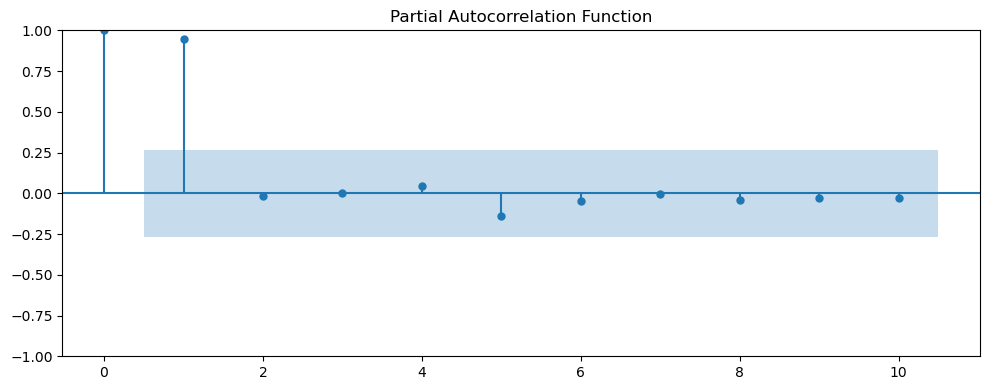

Significant lags (α=0.05): []
No significant lags found - consider AR(1)


In [6]:
# Step 2: Visual check with PACF
pacf_lags = select_lags_pacf(emissions, max_lags=10)

In [16]:
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.linear_model import GLSAR

X = np.column_stack([np.ones(len(years)), years])
model = OLS(emissions, X).fit()

trend = model.fittedvalues
residuals1 = emissions - trend

# trend_info = {
#     "method": 'linear',
#     "trend": trend,
#     'parameter_info': model.params,
#     'standard_errors': model.bse,
# }
X = np.column_stack([np.ones(len(years)), years])
model2 = GLSAR(emissions, X, rho=1).iterative_fit(maxiter=10)
rho = model2.model.rho

trend2 = model2.fittedvalues  # Note: fittedvalues (plural)
residuals2 = emissions - trend2

In [19]:
residuals2

array([ 1359.70602953,  1507.59092759,  1771.48763575,  2174.80761278,
        1643.95300157,  1228.81955445,  1708.32772265,  1761.01062171,
        1874.82376029,  1957.68027068,  1380.332134  ,   457.86478745,
        -150.76829505,  -486.78525299,  -287.76560387,   -80.50181429,
        -234.27562258,   -56.02814062,   322.05017882,   166.5181617 ,
          78.94264423,    96.35753068, -1022.60636022, -1248.81012486,
       -1468.59486625, -1434.7160388 , -1165.85415281, -1477.80828648,
       -1999.24410935, -1953.18142894, -1742.13059478, -2022.92019033,
       -1906.71743175,  -968.69343714,  -454.97814769,    67.25932655,
         632.75883634,  1055.12847354,  1150.25396262,   143.01051084,
        1493.39358028,  2077.34796964,  2029.86269261,  1869.81889505,
        1632.86536577,  1173.21628823,   717.3248801 ,   825.07582543,
        1108.06187921,   950.595337  , -1534.32048152,   -24.64438928,
        -176.1120064 ,  -138.45911008])

In [4]:
peak_tester.characterize_noise(method='linear', noise_type = 'normal') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()


using normal distribution to calculate noise
Autocorrelation analysis:

  Lag-1 autocorr: 0.891
  Residual σ (post-autocorrelation): 569.3
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999999999825153
Noise characterization complete:
  Method used: linear
Using AR(1) noise generator with φ=0.89, mean=-0.000, sigma=569.303


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.ar1_noise_generator(size: int, initial_value: float | None = 0) -> numpy.ndarray>

In [29]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
peak_tester.set_test_data([
                (2025, 37800),
                (2026, 37300), 
                (2027, 36800),
                (2028, 36300)
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')

Test data set: 2025-2028
Test slope: -500.00 Mt CO2 (R² = 1.000)
Recent historical trend: 265.45 Mt CO2
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.0566
  Significant at α=0.1: True
  Effect size: 1.58 standard deviations


In [15]:
peak_tester.bootstrap_results['bootstrap_slopes'][0]

np.float64(280.08200468219724)

In [30]:
np.percentile(peak_tester.bootstrap_results['bootstrap_slopes'], 10)

np.float64(-406.41217131708515)

In [13]:
peak_tester.interpret_results(verbose=True)


INTERPRETATION OF RESULTS
Observed trend: declining at -120.0 Mt CO2
Statistical evidence: insufficient evidence (p = 0.3832)
Conclusion: Declining trend present but not statistically significant


{'direction': 'decline',
 'trend_description': 'declining',
 'peak_conclusion': 'Declining trend present but not statistically significant',
 'confidence_in_peak': 'low',
 'p_value': '0.3832',
 'slope': '-120.0 Mt CO2'}

In [267]:
# Testing what happened in 2015
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))

em_2013 = peak_tester.historical_data.loc[peak_tester.historical_data.year==2013,'emissions'].squeeze()
em_2014 = peak_tester.historical_data.loc[peak_tester.historical_data.year==2014,'emissions'].squeeze()
em_2015 = peak_tester.historical_data.loc[peak_tester.historical_data.year==2015,'emissions'].squeeze()
em_2016 = peak_tester.historical_data.loc[peak_tester.historical_data.year==2016,'emissions'].squeeze()

peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2014))
peak_tester.characterize_noise(method='loess', noise_type = 'normal') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()

peak_tester.set_test_data([
        (2013, em_2013),
        (2014, em_2014), 
        # (2015, em_2015),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')


Loaded historical data: 1971-2023
Data points: 53
Loaded historical data: 1971-2013
Data points: 43
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.403
  Residual σ (post-autocorrelation): 354.3
  Has significant autocorr: True
  Likelihood of autocorr: 0.9858668730185006
Noise characterization complete:
  Method used: loess
Using AR(1) noise generator with φ=0.403
Test data set: 2013-2014
Test slope: 148.44 MtCO2 / yr (R² = 1.000)
Recent historical trend: 739.60 MtCO2 / yr
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.6421
  Significant at α=0.05: False
  Effect size: -0.36 standard deviations


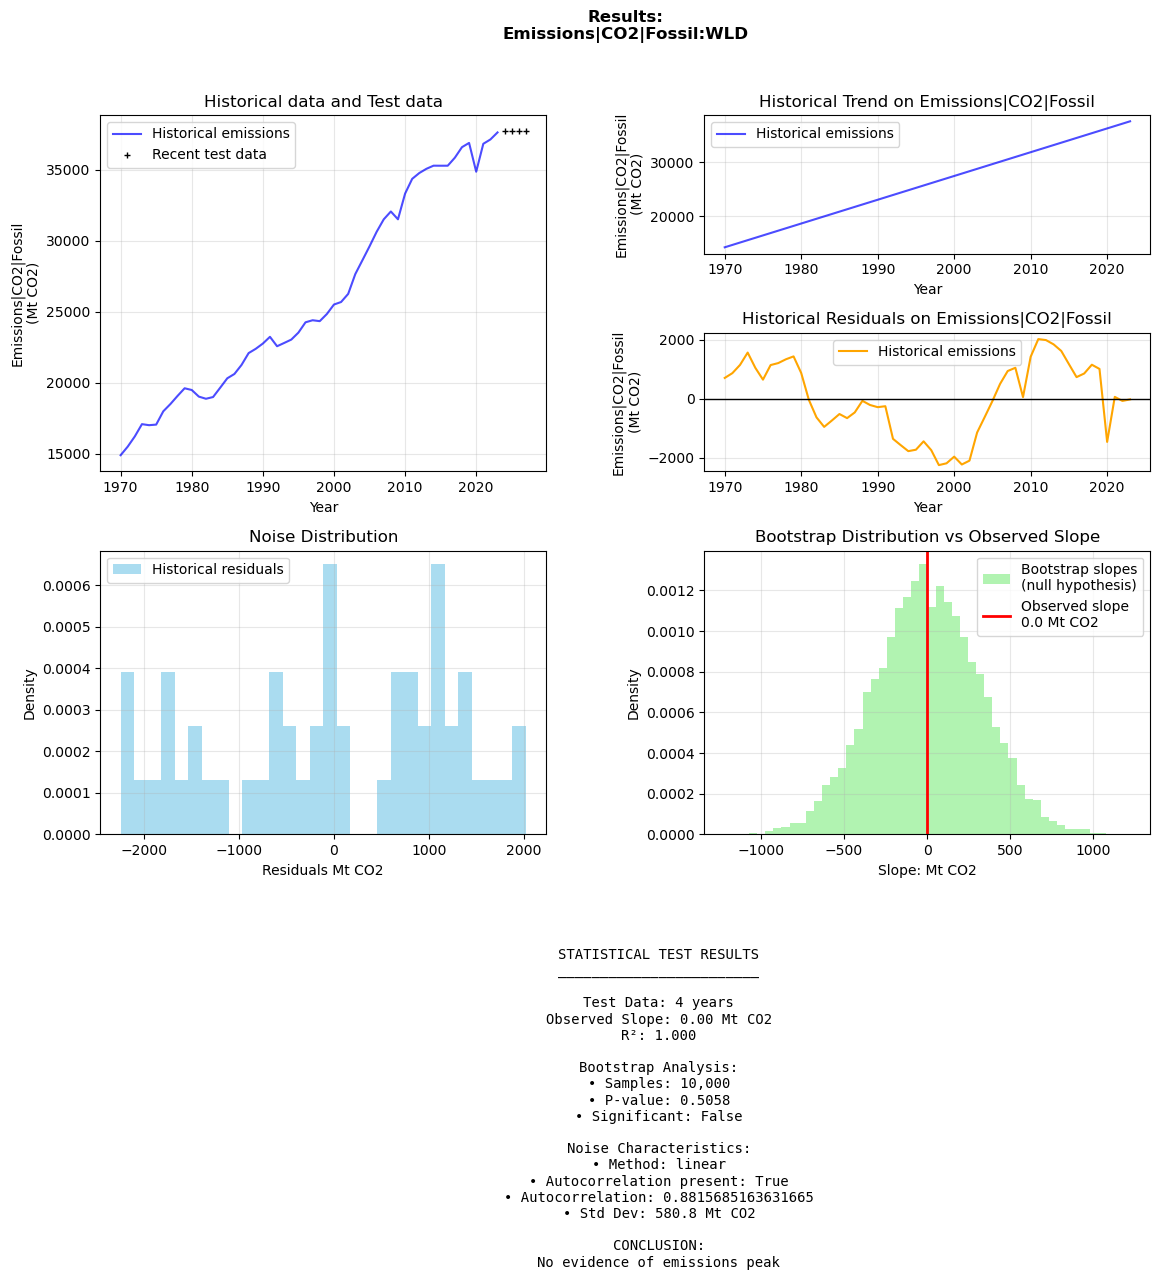

In [7]:
peak_tester.plot_analysis()

In [270]:
## Test different historical years

peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
peak_tester.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()

p_list = []
years_to_check = np.arange(1990, 2021, 1)
for year in years_to_check:
    years_to_test = [year, year+1, year+2]
    
    em_0 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year,'emissions'].squeeze()
    em_1 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year+1,'emissions'].squeeze()
    em_2 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year+2,'emissions'].squeeze()

    # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        peak_tester.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(peak_tester.bootstrap_results['p_value_one_tail'])
    
pdf = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})

print(pdf)


Loaded historical data: 1971-2023
Data points: 53
using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 4.8
Autocorrelation analysis:
  Lag-1 autocorr: 0.336
  Residual σ (post-autocorrelation): 456.8
  Has significant autocorr: True
  Likelihood of autocorr: 0.9617155683630787
Noise characterization complete:
  Method used: loess
Using AR(1) noise generator with φ=0.336
    year  p-value
0   1990   0.3740
1   1991   0.2532
2   1992   0.7600
3   1993   0.8745
4   1994   0.9651
5   1995   0.9004
6   1996   0.5246
7   1997   0.7582
8   1998   0.9566
9   1999   0.8936
10  2000   0.8837
11  2001   0.9938
12  2002   0.9971
13  2003   0.9917
14  2004   0.9947
15  2005   0.9931
16  2006   0.9796
17  2007   0.4968
18  2008   0.9631
19  2009   0.9980
20  2010   0.9866
21  2011   0.8814
22  2012   0.7538
23  2013   0.5582
24  2014   0.4934
25  2015   0.8199
26  2016   0.9666
27  2017   0.9486
28  2018   0.0136
29  2019   0.4398
30  2020   0.9962


In [308]:
# Test different historical years

peak_tester2 = EmissionsPeakTest()
peak_tester2.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = peak_tester2.historical_data
p_list = []
years_to_check = np.arange(1990, 2022, 1)
for year in years_to_check:
    years_to_test = [year, year+1] #, year+2
    
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
    em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()

    # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        peak_tester2.historical_data = hist_data.query(f'year < {year}').copy()
        peak_tester2.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
        peak_tester2.create_noise_generator()
        peak_tester2.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                # (year+2, em_2),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(peak_tester2.bootstrap_results['p_value_one_tail'])
    
pdf2_2year = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})


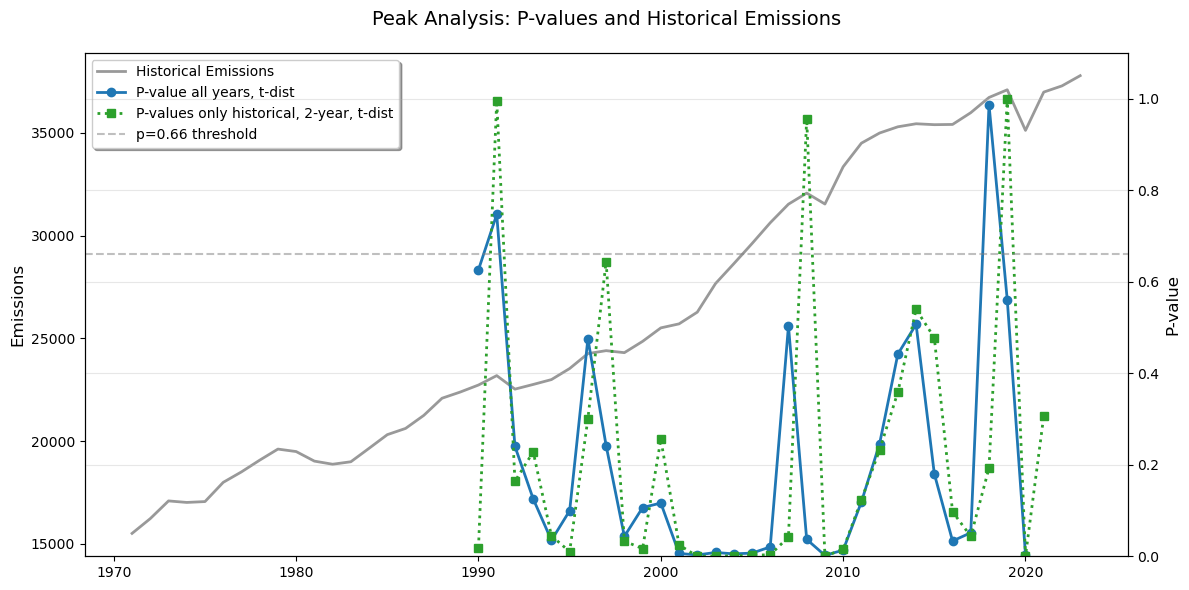

In [321]:
# Plot p-values
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot emissions on the first y-axis
ax1.set_ylabel('Emissions', color='black', fontsize=12)
ax1.plot(peak_tester.historical_data.year, peak_tester.historical_data.emissions, 
         color='gray', linewidth=2, label='Historical Emissions', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='black')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', color='black', fontsize=12)

ax2.plot(pdf['year'], 1-pdf['p-value'], color=color, marker='o', 
         linewidth=2, label='P-value all years, t-dist', markersize=6)
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, alpha=0.3)

# ax2.plot(pdf2['year'], 1-pdf2['p-value'], color='green', marker='o', 
#          linewidth=2, label='P-values only historical, t-dist', markersize=6)
# # ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(pdf2_2year['year'], 1-pdf2_2year['p-value'], color='tab:green', marker='s', linestyle='dotted', 
         linewidth=2, label='P-values only historical, 2-year, t-dist', markersize=6)

# Add horizontal line at 1-p=0.66 for reference
ax2.axhline(y=0.66, color='gray', linestyle='--', alpha=0.5, label='p=0.66 threshold')
# Set y-limits for p-values with some padding
max_p = max(pdf['p-value'].max(), pdf2['p-value'].max())
ax2.set_ylim(0, max_p * 1.1)


# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, 
           fancybox=True, shadow=True)

plt.savefig("../figures/pvalue_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

### Test impact of adding ignore_years

In [9]:
peak_tester.characterize_noise(method='hp')
peak_tester.characterize_noise(method='hp',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

Autocorrelation analysis:
  Lag-1 autocorr: 0.399
  Residual σ (post-autocorrelation): 462.1
  Has significant autocorr: True
  Likelihood of autocorr: 0.9891095773301503
Noise characterization complete:
  Method used: hp
Autocorrelation analysis:
  Lag-1 autocorr: 0.741
  Residual σ (post-autocorrelation): 333.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999999618417601
Noise characterization complete:
  Method used: hp


In [10]:
peak_tester.characterize_noise(method='loess')
peak_tester.characterize_noise(method='loess',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

Autocorrelation analysis:
  Lag-1 autocorr: 0.406
  Residual σ (post-autocorrelation): 468.9
  Has significant autocorr: True
  Likelihood of autocorr: 0.9909892669917686
Noise characterization complete:
  Method used: loess
Autocorrelation analysis:
  Lag-1 autocorr: 0.591
  Residual σ (post-autocorrelation): 329.1
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999165983843805
Noise characterization complete:
  Method used: loess


In [21]:
peak_tester.characterize_noise(method='hamilton')
peak_tester.characterize_noise(method='hamilton',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

Autocorrelation analysis:
  Lag-1 autocorr: -0.006
  Residual σ (post-autocorrelation): 628.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.006321216204221769
Noise characterization complete:
  Method used: hamilton
Autocorrelation analysis:
  Lag-1 autocorr: 0.081
  Residual σ (post-autocorrelation): 355.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.32845341857014765
Noise characterization complete:
  Method used: hamilton


### Test impact of changing fraction for LOESS
Fraction is one of the main parameters in LOESS – how much of the time series do you use as the locally weighted regression? 

In [13]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [15]:
noise_params = []
peaking_likelihood = []

with HiddenPrints():
    for frac in np.linspace(0.1,0.9,17):
        (
            peak_tester
            .characterize_noise(method='loess',fraction=frac)
            .create_noise_generator()
        )
        (    peak_tester
            .set_test_data([
                (2025, 37700),
                (2026, 37580), 
                (2027, 37460),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )


        noise_params.append(peak_tester.autocorr_params)
        peaking_likelihood.append(peak_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions on the \nlikelihood that emissions have peaked')

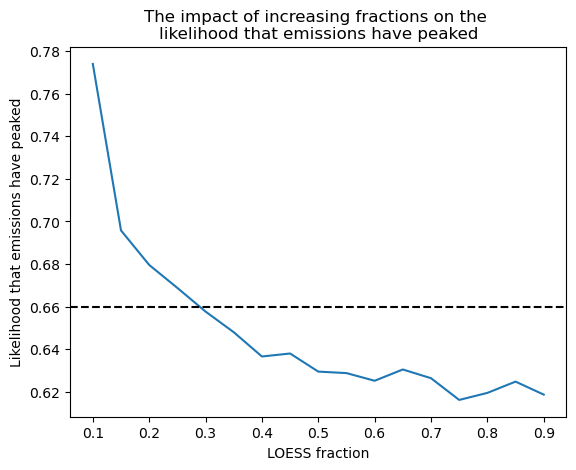

In [16]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[1-s for s in peaking_likelihood])
ax.set_ylabel('Likelihood that emissions have peaked')
ax.set_xlabel('LOESS fraction')
ax.axhline(y=0.66,color='k',ls='--')
ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')

# LOESS fraction of 0.1 ~= 5 year trend, 0.2 ~= 10 trends (with 54 data points)

Text(0.5, 1.0, 'The impact of increasing fractions \n on the estimate of noise')

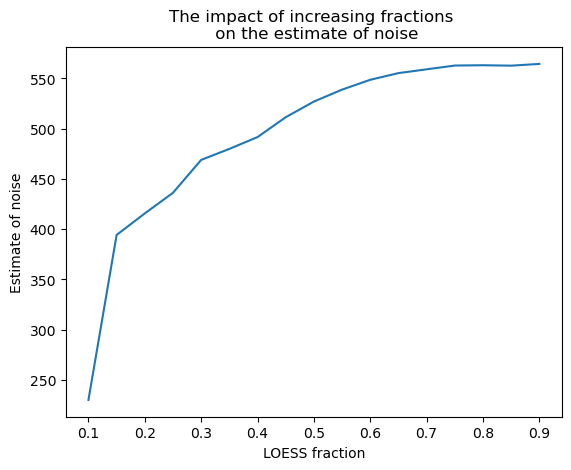

In [19]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[noise_params[i]['sigma_residuals'] for i in range(17)])
ax.set_ylabel('Estimate of noise')
ax.set_xlabel('LOESS fraction')
ax.set_title('The impact of increasing fractions \n on the estimate of noise')

# LOESS fraction of 0.1 ~= 5 year trend, 0.2 ~= 10 trends (with 54 data points)

## Testing impact of different noise distribution types

Loaded historical data: 1970-2023
Data points: 54


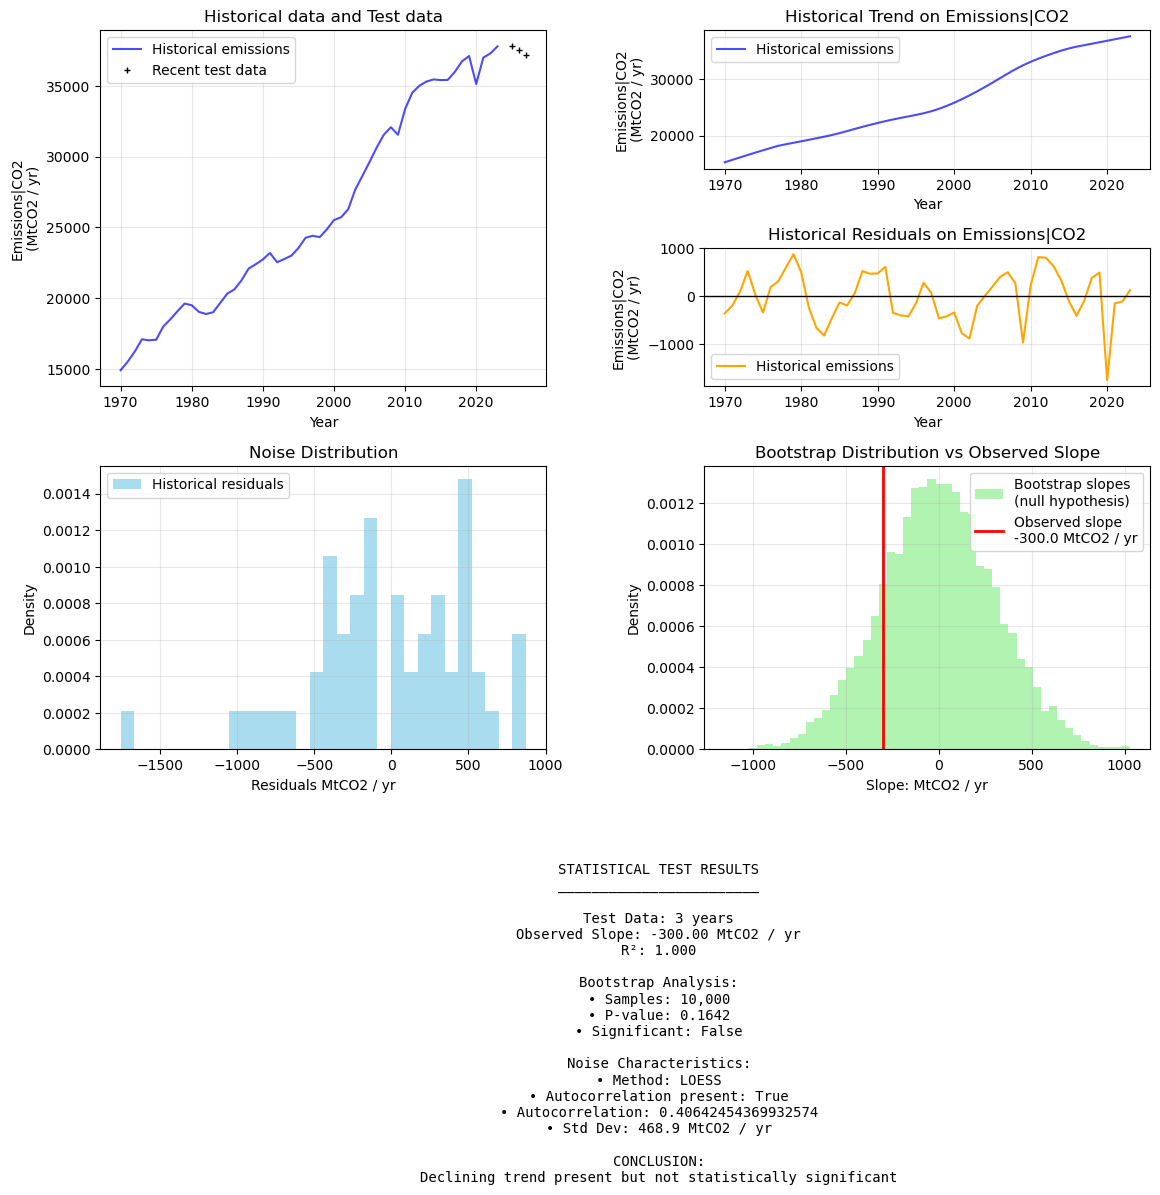

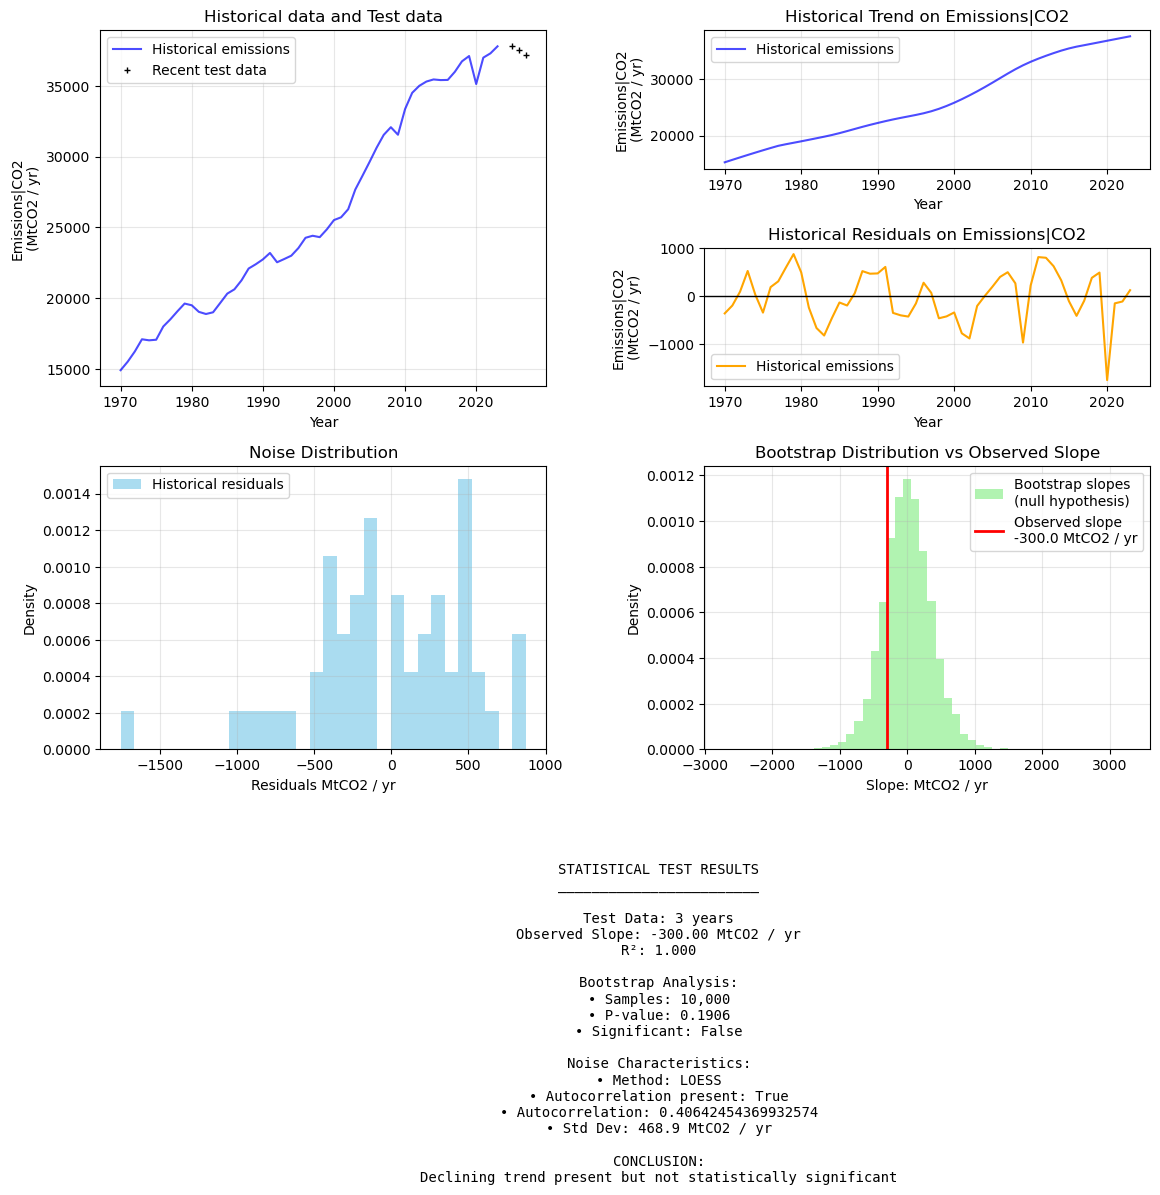

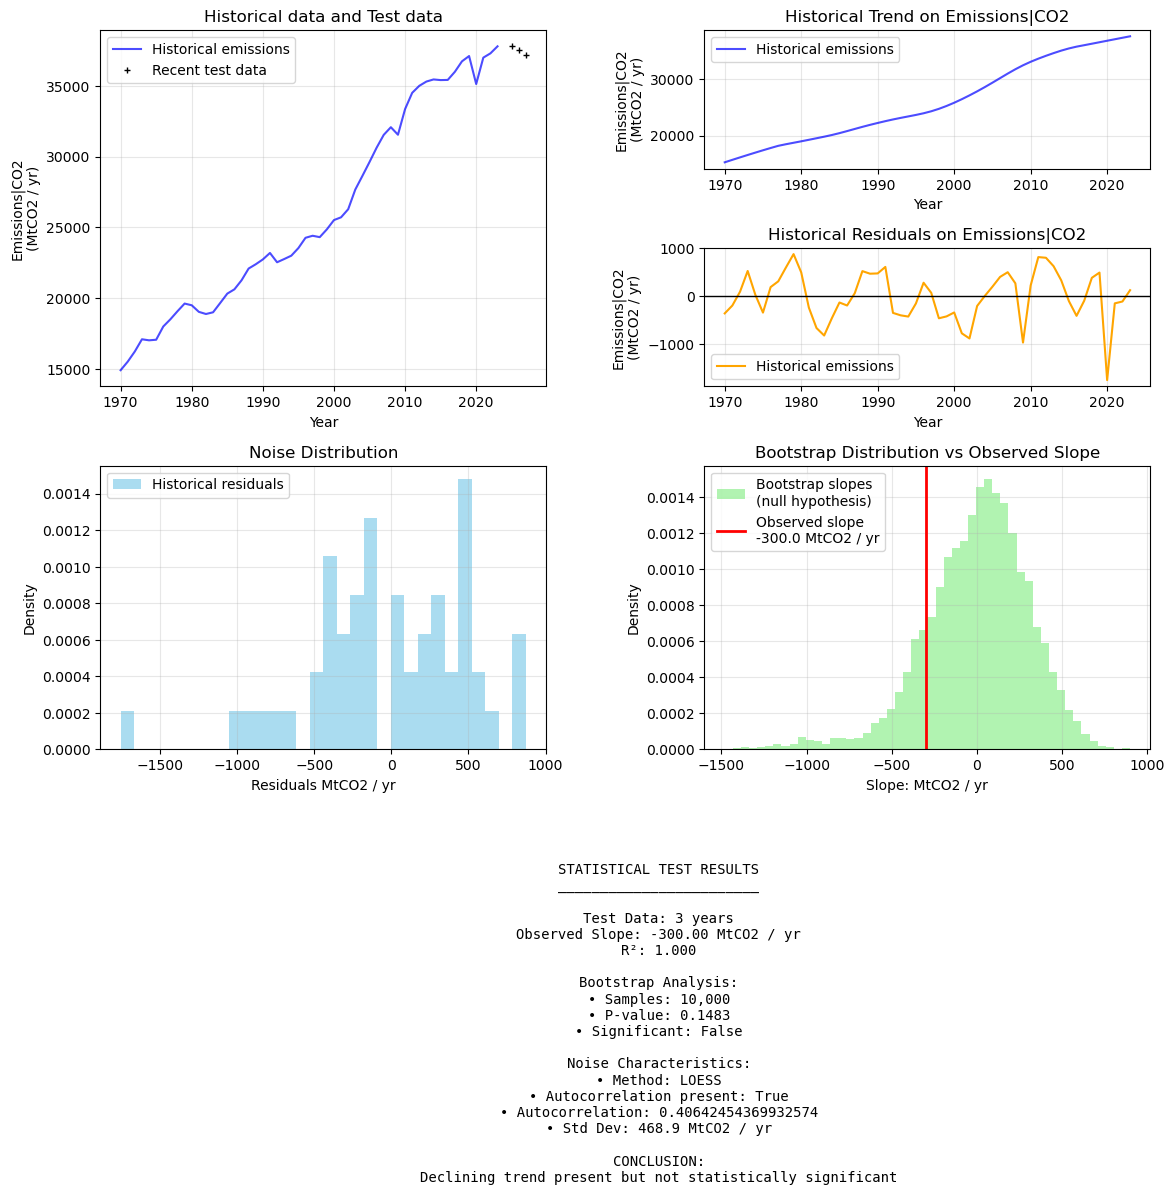

In [14]:
# Testing with data to 2014 and then 2015 and 2016 to see how likely it thinks peaking is - and the answer is not very :)
# t-distribution seems to be the most conservative.
noise_params = []
peaking_likelihood = []
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', year_range = range(1970,2024))

with HiddenPrints():
    for noise_type in ["normal", "t-dist", "empirical"]:
        (
            peak_tester
            .characterize_noise(method='loess',noise_type=noise_type)
            .create_noise_generator()
        )
        (    peak_tester
            .set_test_data([(2025, 37800),
                            (2026, 37500), 
                            (2027, 37200)
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )
        peak_tester.plot_analysis()


        noise_params.append(peak_tester.autocorr_params)
        peaking_likelihood.append(peak_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions on the \nlikelihood that emissions have peaked')

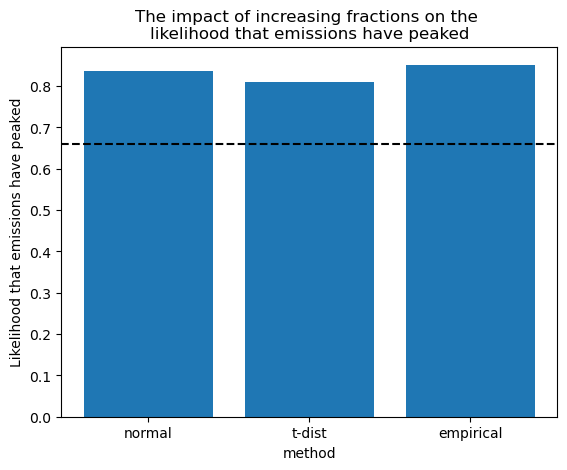

In [15]:
f, ax = plt.subplots()
ax.bar(["normal", "t-dist", "empirical"], [1-s for s in peaking_likelihood])
ax.set_ylabel('Likelihood that emissions have peaked')
ax.set_xlabel('method')
ax.axhline(y=0.66, color='k', ls='--')
ax.set_title('The impact of increasing fractions on the \nlikelihood that emissions have peaked')


## Implementation on carbon intensity
Test applying the peak tester to carbon intensity instead, which abstracts out the GDP growth component

In [239]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data(
    'fossil_intensity.csv', year_range = range(1971,2024))

Loaded historical data: 1971-2023
Data points: 53


In [17]:
ci_noise_params = []
ci_peaking_likelihood = []

with HiddenPrints():
    for frac in np.linspace(0.1,0.9,17):
        (
            carbon_intensity_tester
            .characterize_noise(method='loess',fraction=frac)
            .create_noise_generator()
        )
        (    carbon_intensity_tester
            .set_test_data([
                (2025, 37700),
                (2026, 37580), 
                (2027, 37460),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        )


        ci_noise_params.append(carbon_intensity_tester.autocorr_params)
        ci_peaking_likelihood.append(carbon_intensity_tester.bootstrap_results['p_value_one_tail'])
        

Text(0.5, 1.0, 'The impact of increasing fractions \n on the estimate of noise')

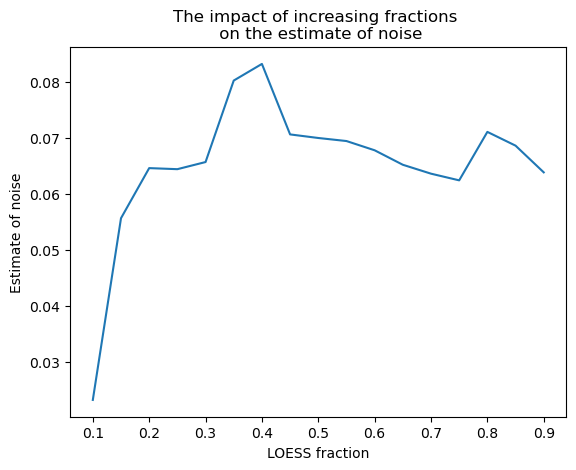

In [18]:
f, ax = plt.subplots()
ax.plot(np.linspace(0.1,0.9,17),[ci_noise_params[i]['sigma_residuals'] for i in range(17)])
ax.set_ylabel('Estimate of noise')
ax.set_xlabel('LOESS fraction')
ax.set_title('The impact of increasing fractions \n on the estimate of noise')

# LOESS fraction of 0.1 ~= 3 year trend, 0.2 ~= 6 trends (with ~30 data points)

Let's assume that GDP is growing at 2% per year over a three year period. Therefore we want to test if carbon intensity is falling more than 2% per year (which would be needed to offset a GDP growth trend)

In [240]:
carbon_intensity_tester.characterize_noise(method='loess',fraction=0.1, noise_type = 't-dist').create_noise_generator()

using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 0.5
Autocorrelation analysis:
  Lag-1 autocorr: -0.006
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: False
  Likelihood of autocorr: 0.10318839950583258
Noise characterization complete:
  Method used: loess
Using white noise generator with σ=0.0


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.white_noise_generator(size: int, initial_value: float = 0) -> numpy.ndarray>

In [241]:
ci_2023 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2023,'emissions'].squeeze()

Test data set: 2025-2027
Test slope: -0.01 kgCO2 / $ (R² = 1.000)
Recent historical trend: -0.01 kgCO2 / $
Running complete bootstrap test...
  Null hypothesis: trend of -0.00706577408 / yr
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.3334
  Significant at α=0.05: False
  Effect size: 0.43 standard deviations


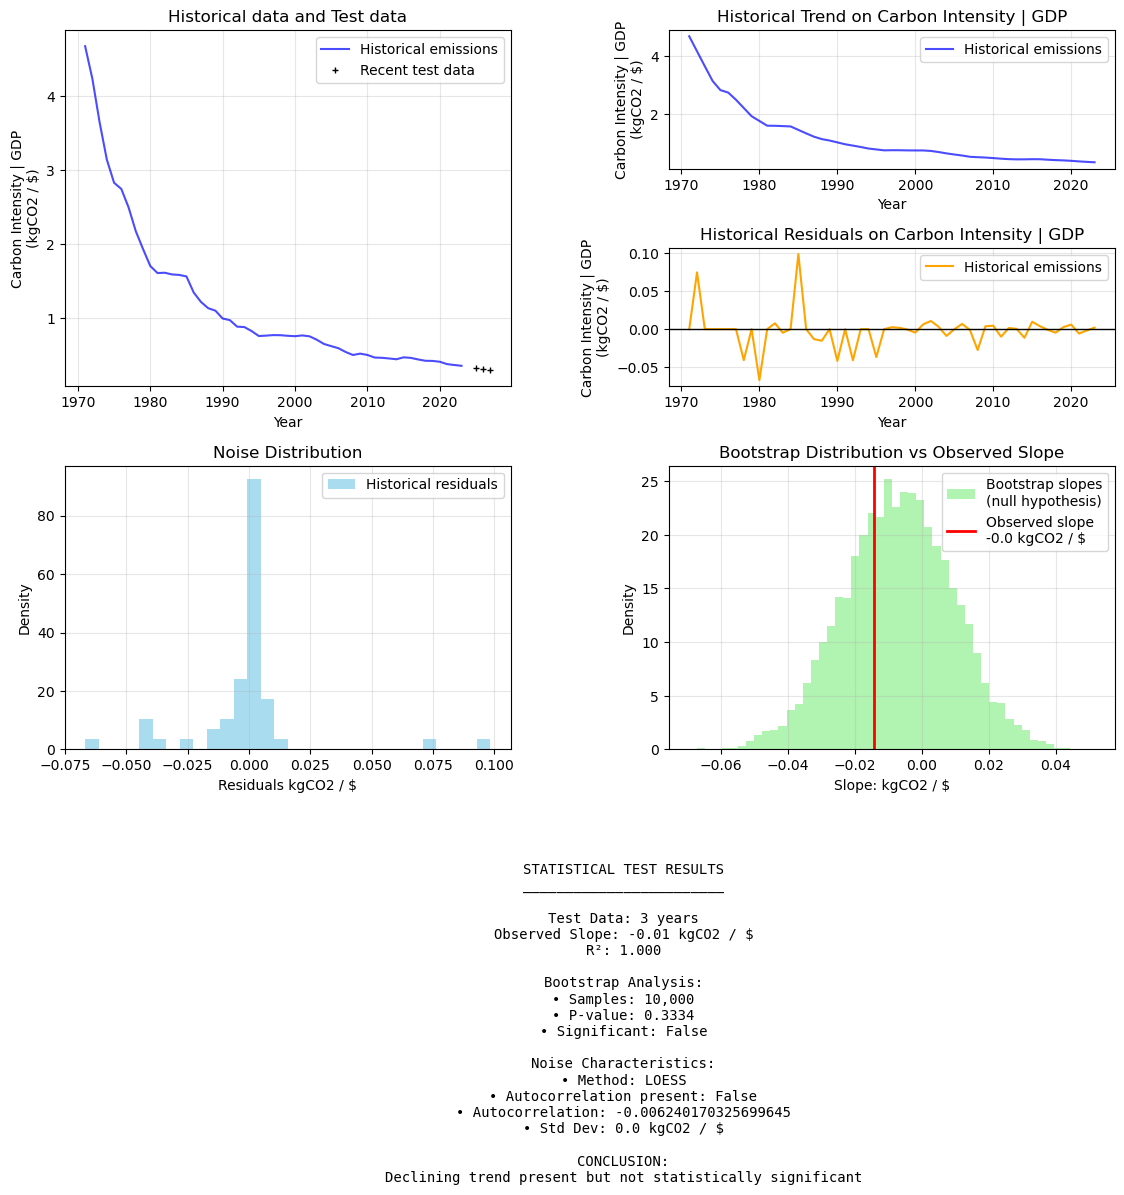

In [132]:

carbon_intensity_tester.set_test_data([
        (2025, ci_2023*0.955**2),
        (2026, ci_2023*0.955**3), 
        (2027, ci_2023*0.955**4),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2023*-0.02)

carbon_intensity_tester.plot_analysis()

Test data set: 2025-2027
Test slope: -0.01 kgCO2 / $ (R² = 0.615)
Recent historical trend: -0.01 kgCO2 / $
Running complete bootstrap test...
  Null hypothesis: trend of -0.00706577408 / yr
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.4614
  Significant at α=0.05: False
  Effect size: 0.09 standard deviations


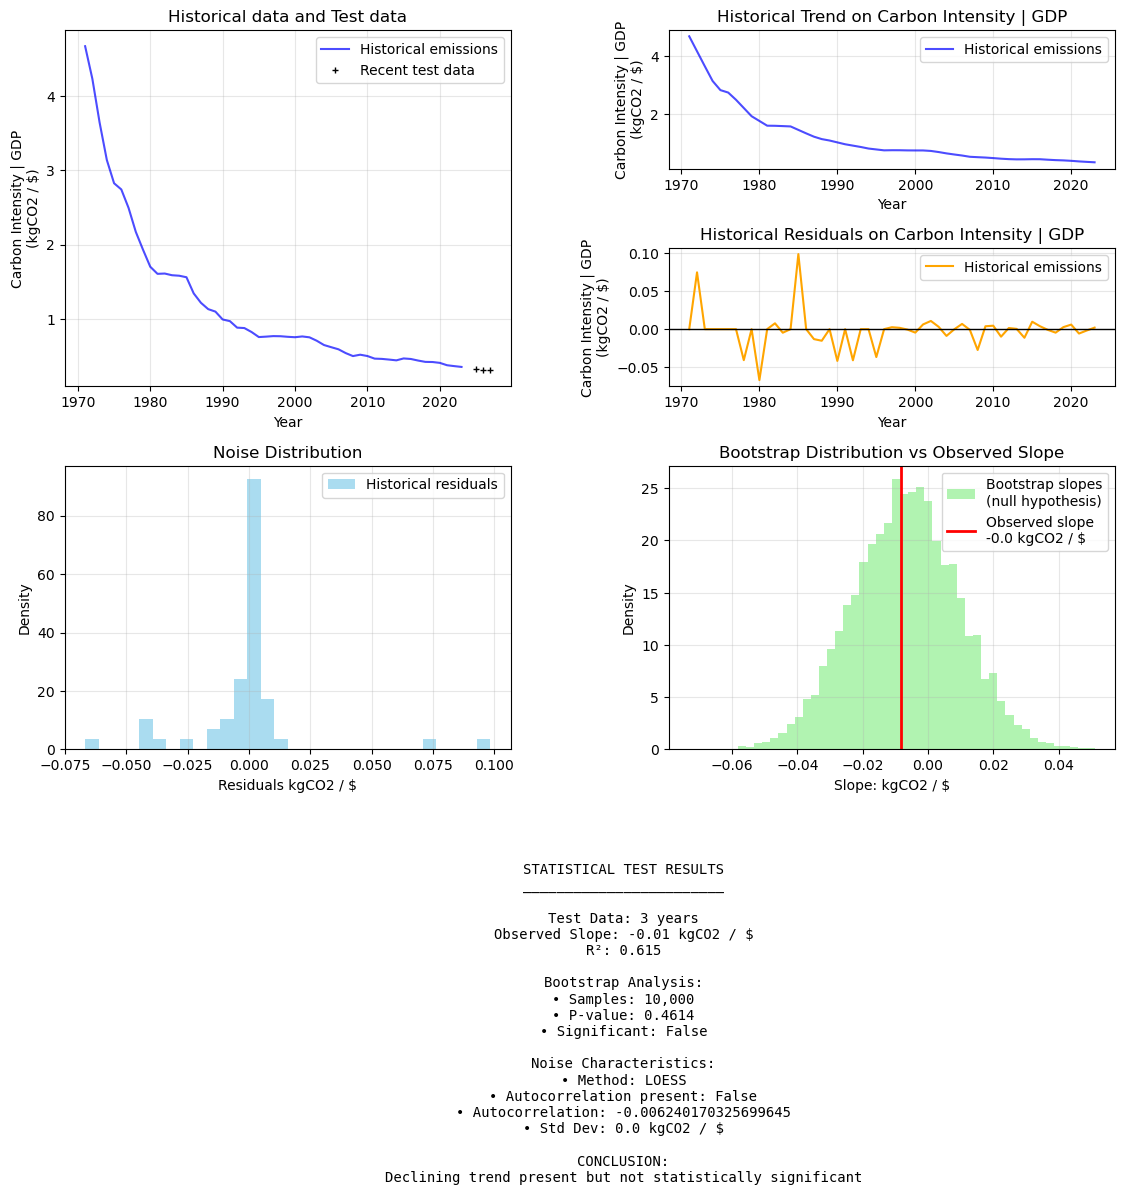

In [209]:

carbon_intensity_tester.set_test_data([
    # (2024, 37800*1e9/(gdp_2023*1.02)),
    # (2025, 37800*1e9/(gdp_2023*1.02**2)),
    # (2026, 37500*1e9/(gdp_2023*1.02**3)), 
    # (2027, 37200*1e9/(gdp_2023*1.02**4))
    # (2024, ci_2023*0.98),
    (2025, ci_2023*0.98*0.95),
    (2026, ci_2023*0.98*0.95*0.94),
    (2027, ci_2023*0.98*0.95*0.94*1.01)
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2023*-0.02)

carbon_intensity_tester.plot_analysis()

Loaded historical data: 1971-2023
Data points: 53
Loaded historical data: 1971-2013
Data points: 43
using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 0.9
Autocorrelation analysis:
  Lag-1 autocorr: -0.045
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: False
  Likelihood of autocorr: 0.04689641133893141
Noise characterization complete:
  Method used: loess
Using white noise generator with σ=0.0
Test data set: 2013-2015
Test slope: 0.01 kgCO2 / $ (R² = 0.351)
Recent historical trend: -0.02 kgCO2 / $
Running complete bootstrap test...
  Null hypothesis: trend of -0.01325279667 / yr
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.8333
  Significant at α=0.05: False
  Effect size: -0.97 standard deviations


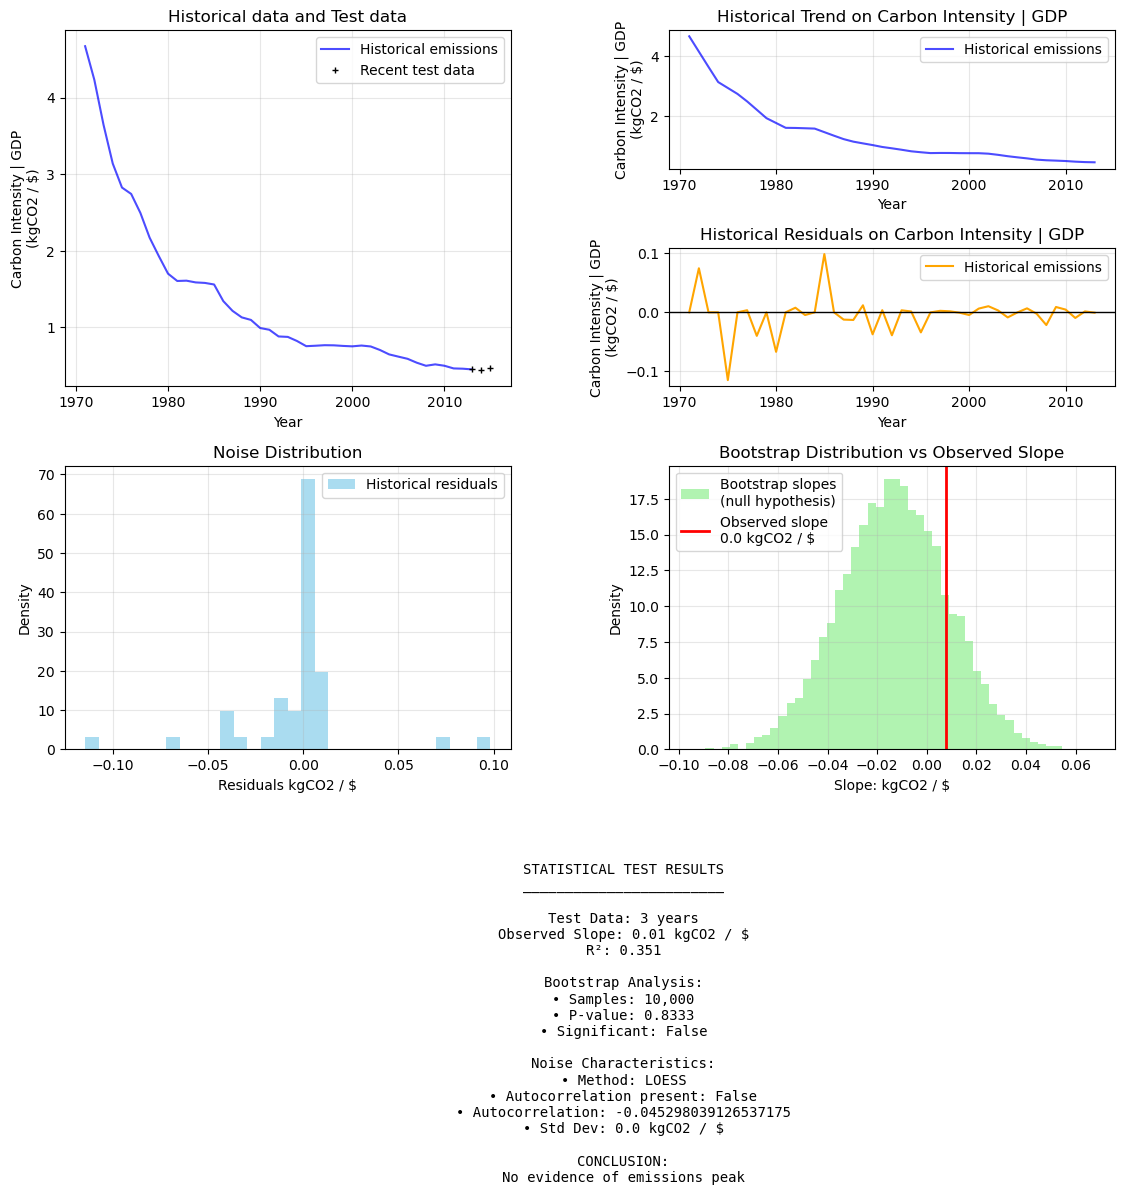

In [256]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data('fossil_intensity.csv', year_range = range(1971,2024))

ci_2013 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2013,'emissions'].squeeze()
ci_2014 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2014,'emissions'].squeeze()
ci_2015 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2015,'emissions'].squeeze()
ci_2016 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2016,'emissions'].squeeze()

carbon_intensity_tester.load_historical_data('fossil_intensity.csv', year_range = range(1971,2014))
carbon_intensity_tester.characterize_noise(method='loess',fraction=0.1, noise_type = 't-dist').create_noise_generator()
carbon_intensity_tester.set_test_data([
    (2013, ci_2013),
    (2014, ci_2014),
    (2015, ci_2015),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2014*-0.03)

carbon_intensity_tester.plot_analysis()

# GDP

In [111]:
# Read the file (pandas will auto-detect the delimiter)
df = pd.read_csv('../data/gdp_wb.csv', sep=None, engine='python', decimal = '.')

# Save with explicit comma delimiter
df.to_csv('../data/gdp_wb2.csv', sep=',', index=False)

In [112]:
# data adjustments - only need once
df = pd.read_csv('../data/gdp_wb2.csv')

# Get all year columns
year_columns = [col for col in df.columns if str(col).isdigit() or col.startswith('19') or col.startswith('20')]

# Fix European scientific notation and convert to float
for col in year_columns:
    # Convert to string, replace comma with period
    df[col] = df[col].astype(str).str.replace(',', '.')
    # Convert to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')



df = df.set_index(['region','variable', 'unit'])
# df = df.drop('Unnamed: 0', axis=1)
df.to_csv('../data/gdp_wb2.csv')

In [114]:
gdp_tester = EmissionsPeakTest()
gdp_tester.load_historical_data(
    'gdp_wb2.csv', year_range = range(1990,2024))

Loaded historical data: 1990-2023
Data points: 34


In [141]:
gdp_tester.characterize_noise(method='loess', noise_type = 't-dist')

using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 1.5
Autocorrelation analysis:
  Lag-1 autocorr: 0.149
  Residual σ (post-autocorrelation): 1547644776029.8
  Has significant autocorr: True
  Likelihood of autocorr: 0.8506042105453956
Noise characterization complete:
  Method used: loess


In [142]:
gdp_2023 = gdp_tester.historical_data.loc[gdp_tester.historical_data.year==2023, 'emissions'].squeeze()

In [143]:
gdp_tester.create_noise_generator()

Using AR(1) noise generator with φ=0.149


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.ar1_noise_generator(size: int, initial_value: float | None = 0) -> numpy.ndarray>

In [253]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
gdp_2013 = gdp_tester.historical_data.loc[gdp_tester.historical_data.year==2013,'emissions'].squeeze()
gdp_2014 = gdp_tester.historical_data.loc[gdp_tester.historical_data.year==2014,'emissions'].squeeze()
gdp_2015 = gdp_tester.historical_data.loc[gdp_tester.historical_data.year==2015,'emissions'].squeeze()
gdp_tester.set_test_data([
        (2013, gdp_2013),
        (2014, gdp_2014), 
        # (2015, gdp_2015),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap', null_hypothesis='gdp_2013*0.02')
print(f"GDP reduction rate: {gdp_tester.test_slope/gdp_2013}")

Test data set: 2013-2014
Test slope: 4000000000000.00 $ (R² = 1.000)
Recent historical trend: 4175757575757.57 $
Running complete bootstrap test...
  Null hypothesis: gdp_2013*0.02
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.9095
  Significant at α=0.05: False
  Effect size: -0.40 standard deviations
GDP reduction rate: 0.03225806451612903


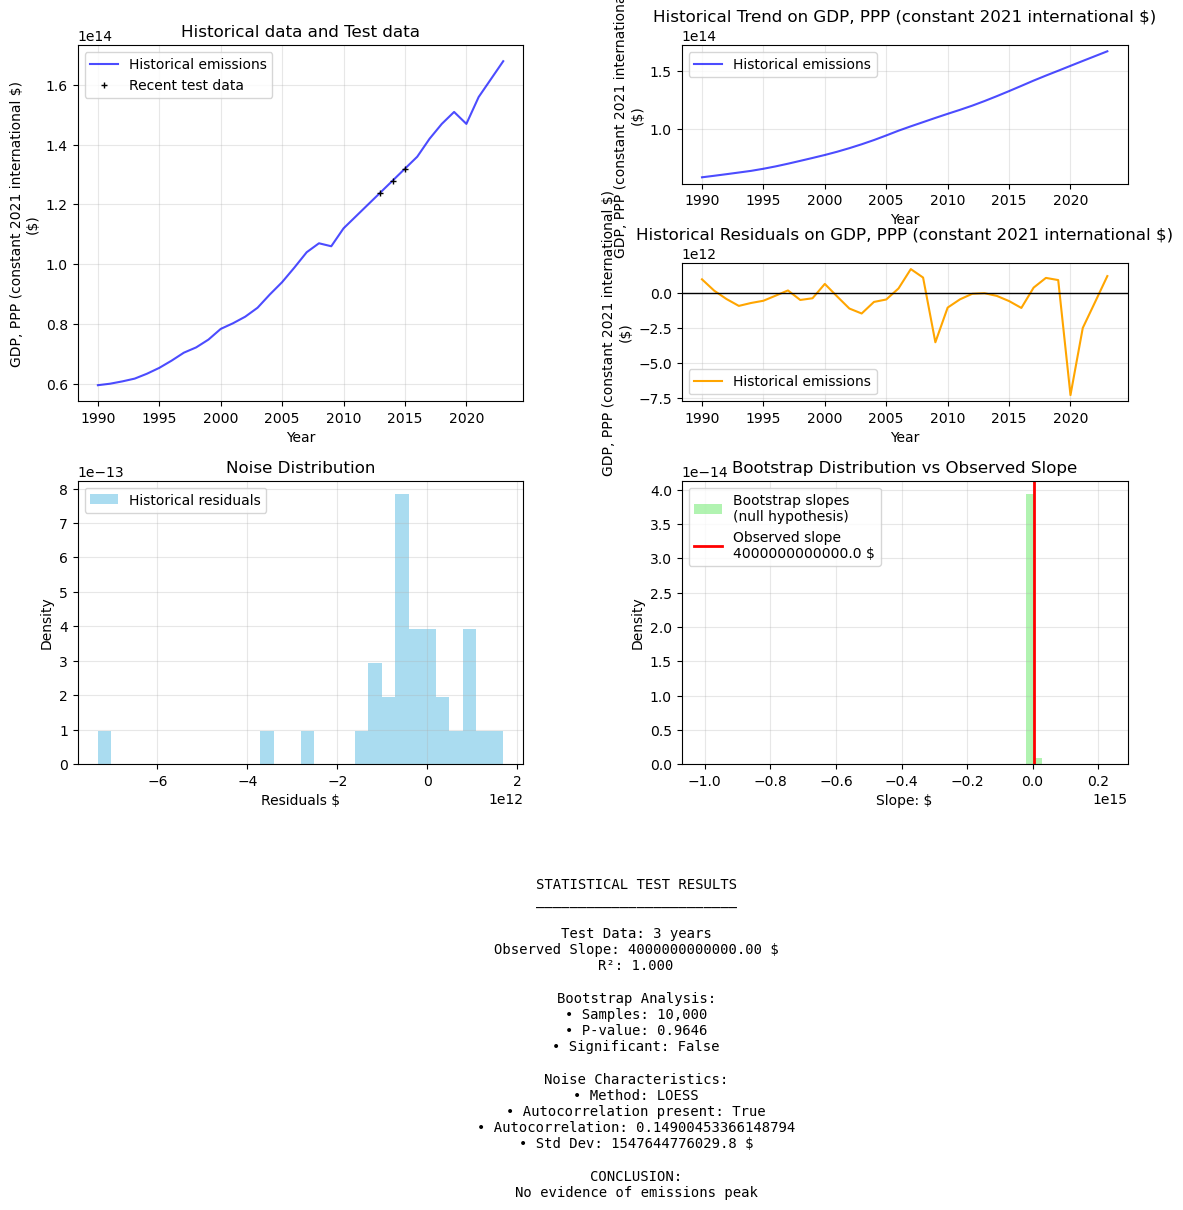

In [250]:
gdp_tester.plot_analysis()

# calculate C intensity from gdp and emissions data

In [159]:
co2 = peak_tester.historical_data
gdp = gdp_tester.historical_data

In [168]:
ci = co2['emissions']*1e9/gdp['emissions']

In [212]:
ci_tmp = []
for year in gdp['year']:
    gdp_yr = gdp.loc[gdp['year']==year,'emissions'].values[0]
    co2_yr = co2.loc[co2['year']==year, 'emissions'].values[0]
    ci_yr = co2_yr*1e9/gdp_yr
    ci_tmp.append([year, ci_yr])


In [215]:
carbon_intensity_tester = EmissionsPeakTest()
ci = pd.DataFrame(ci_tmp, columns = ['year', 'emissions'])

In [230]:
ci_tester = EmissionsPeakTest()
ci_tester.historical_data = ci
ci_tester.unit = 'kgCO2/$'
ci_tester.variable = 'carbon intensity'

In [236]:
ci_2023 = ci.loc[ci['year']==2023, 'emissions'].squeeze()

ci_tester.characterize_noise(method='loess', fraction=0.5, noise_type = 't-dist')
ci_tester.create_noise_generator()
ci_tester.set_test_data([
    (2025, 37800*1e9/(gdp_2023*1.02**2)),
    (2026, 37500*1e9/(gdp_2023*1.02**3)), 
    (2027, 37200*1e9/(gdp_2023*1.02**4))
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap', null_hypothesis='ci_2023*-0.02')

using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 2.2
Autocorrelation analysis:
  Lag-1 autocorr: 0.470
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.9898785842157812
Noise characterization complete:
  Method used: loess
Using AR(1) noise generator with φ=0.470
Test data set: 2025-2027
Test slope: -0.01 kgCO2/$ (R² = 1.000)
Recent historical trend: -0.01 kgCO2/$
Running complete bootstrap test...
  Null hypothesis: ci_2023*-0.02
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.0485
  Significant at α=0.05: True
  Effect size: 1.06 standard deviations


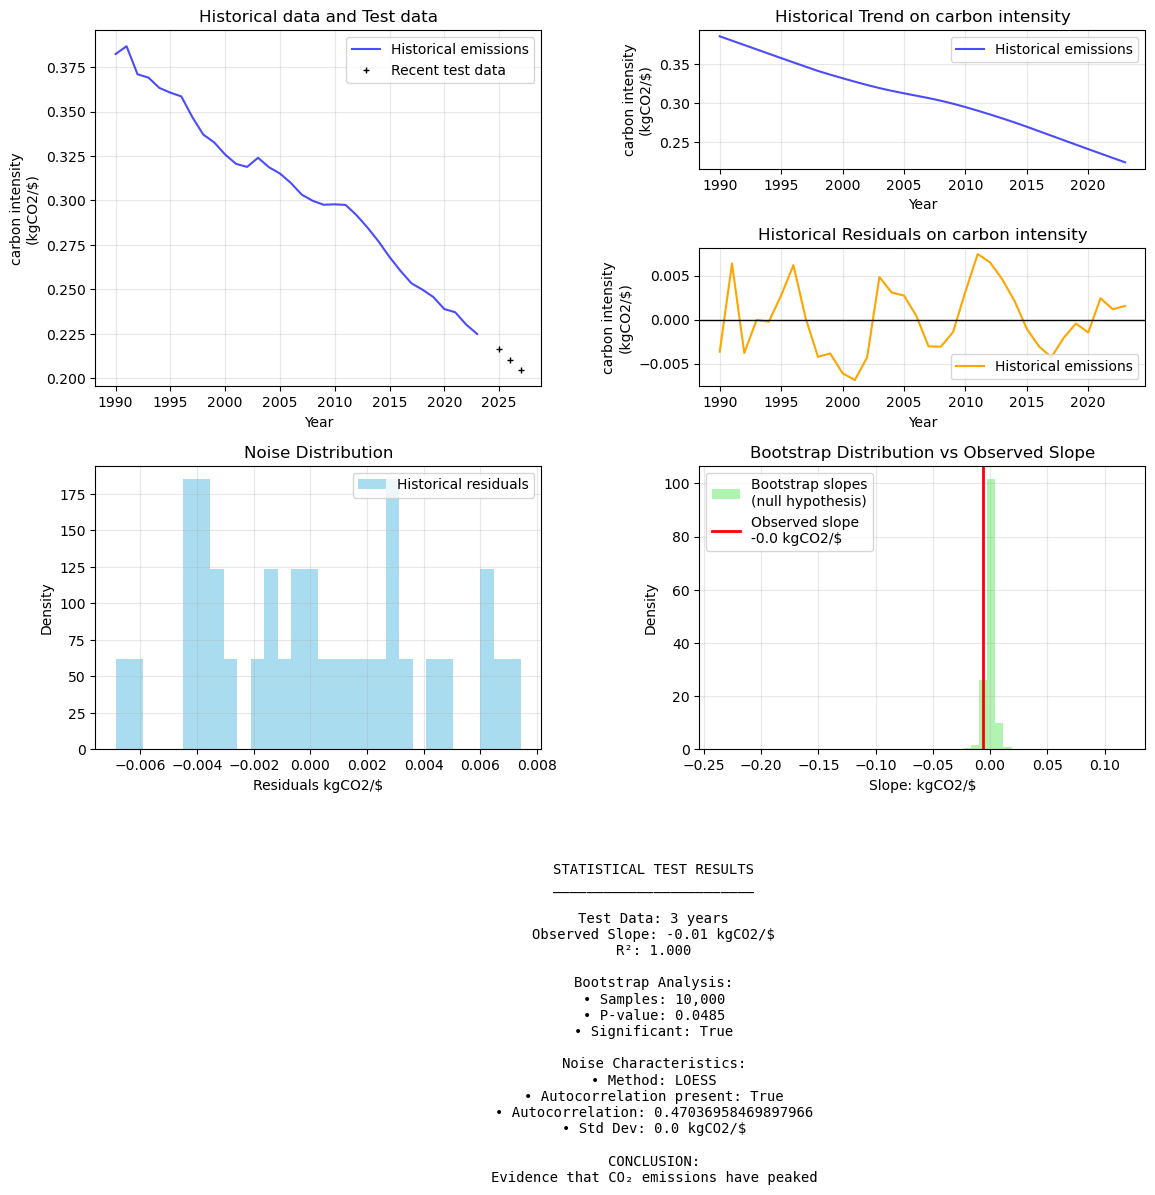

In [237]:
ci_tester.plot_analysis()